In [393]:



from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import log
from sklearn.preprocessing import StandardScaler

import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from tsextract.feature_extraction.extract import build_features, build_features_forecast
from tsextract.domain.statistics import mean, median, std
from tsextract.plots.eval import actualPred, get_lag_corr, scatter


from plotnine import *



import warnings
warnings.filterwarnings("ignore")

In [394]:
#!pip install tsextract

In [395]:

data=pd.read_csv('data_half_cleaned.csv', parse_dates=['date'], index_col=0)

data.head(5)


,order_id,date,item_code,quantity,unit_price_vat_excl,unit_cogs,net_revenue,gross_revenue,margin_revenue,country,item_name,style,name,group0,group1,category
0,1.900052e+09,2019-06-04,ZB00025746,1,9.412096,0.000000,9.412096,0.000000,9.412096,Romania,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
1,1.900101e+09,2019-07-15,ZB00025746,1,8.648837,5.393411,8.648837,5.393411,3.255426,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
2,1.900107e+09,2019-07-24,ZB00025746,1,8.648837,5.458527,8.648837,5.458527,3.190310,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
3,1.900111e+09,2019-08-01,ZB00025746,1,8.648837,5.440310,8.648837,5.440310,3.208527,Czech Republic,YTH LEAGUE KNIT SHORT NB,725990-010,Nike,Apparel,Pants,football
4,1.900052e+09,2019-06-04,ZB00022010,1,12.784729,4.087597,12.784729,4.087597,8.697132,Romania,NK MERC LT GRD,sp2120-703,Nike,Equipment,Guards,football


In [396]:
data=data.sort_values(by=['date'], ascending=False)


In [397]:
data.head()

,order_id,date,item_code,quantity,unit_price_vat_excl,unit_cogs,net_revenue,gross_revenue,margin_revenue,country,item_name,style,name,group0,group1,category
1351860,2.100190e+09,2021-05-07,ZB00227894,1,70.568867,37.635659,70.568867,37.635659,32.933208,Romania,PREDATOR FREAK .3 SG,fw7516,adidas,Other,NaN,NaN
216718,2.100190e+09,2021-05-07,S113,1,0.791378,0.000000,0.791378,0.000000,0.791378,Slovakia,Platba,NaN,- žádný výrobce -,Other,NaN,NaN
216710,2.100190e+09,2021-05-07,S113,1,0.572899,0.000000,0.572899,0.000000,0.572899,Hungary,Platba,NaN,- žádný výrobce -,Other,NaN,NaN
216711,2.100190e+09,2021-05-07,S113,1,0.572899,0.000000,0.572899,0.000000,0.572899,Hungary,Platba,NaN,- žádný výrobce -,Other,NaN,NaN
216712,2.100190e+09,2021-05-07,S113,1,0.572899,0.000000,0.572899,0.000000,0.572899,Hungary,Platba,NaN,- žádný výrobce -,Other,NaN,NaN


In [398]:
#Total sales based on day
df_daily=data.resample('D', on='date').net_revenue.sum()
df_daily.to_frame()

,net_revenue
date,
2019-06-01,27686.366016
2019-06-02,3511.559646
2019-06-03,7006.124367
2019-06-04,80530.520659
2019-06-05,86484.287754
...,...
2021-05-03,83381.216551
2021-05-04,86039.908417
2021-05-05,86122.130266


In [399]:
#total sales based on week
data.resample('W', on='date').net_revenue.sum().to_frame()


,net_revenue
date,
2019-06-02,31197.925662
2019-06-09,218374.722548
2019-06-16,138748.856953
2019-06-23,263338.411548
2019-06-30,149753.706266
...,...
2021-04-11,731112.360278
2021-04-18,739655.464074
2021-04-25,619745.438899


In [400]:
#total sales based on Month
data.resample('MS', on='date').net_revenue.sum().to_frame()

,net_revenue
date,
2019-06-01,8.014136e+05
2019-07-01,1.106330e+06
2019-08-01,1.517583e+06
2019-09-01,1.320894e+06
2019-10-01,1.074521e+06
2019-11-01,1.816199e+06
2019-12-01,1.816386e+06
2020-01-01,1.427921e+06
2020-02-01,1.247982e+06


<AxesSubplot:>

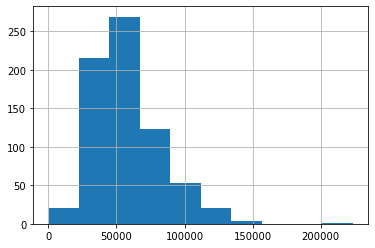

In [401]:
df_daily.hist()


In [402]:
#Total sales based on day
df_sales=data[['date', 'net_revenue']]
df_sales.columns=['date','sales']
df_sales.head()


,date,sales
1351860,2021-05-07,70.568867
216718,2021-05-07,0.791378
216710,2021-05-07,0.572899
216711,2021-05-07,0.572899
216712,2021-05-07,0.572899


In [403]:
# Daily Total Sales
daily_sales=df_sales.resample('D', on='date').sales.sum().to_frame()
daily_sales

,sales
date,
2019-06-01,27686.366016
2019-06-02,3511.559646
2019-06-03,7006.124367
2019-06-04,80530.520659
2019-06-05,86484.287754
...,...
2021-05-03,83381.216551
2021-05-04,86039.908417
2021-05-05,86122.130266


# Let's check if the dataset is stationary or non-stationary

In [404]:
X = daily_sales.values
split = len(X) // 2
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=44583.580665, mean2=70709.683391
variance1=408384324.542668, variance2=553246259.086531


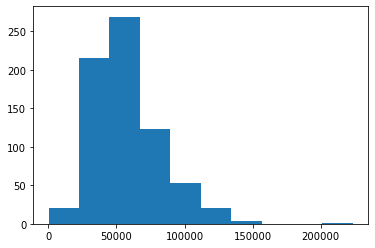

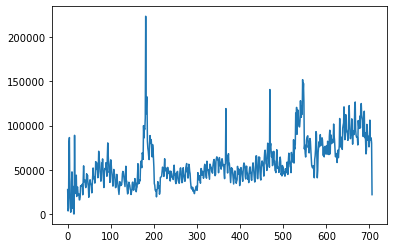

In [405]:
X=daily_sales.values

pyplot.hist(X)
pyplot.show()
pyplot.plot(X)
pyplot.show()

In [406]:
X=daily_sales.values
result=adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.211010
p-value: 0.019356
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


 It means the data is stationary because its p-value is less than 0.05. 

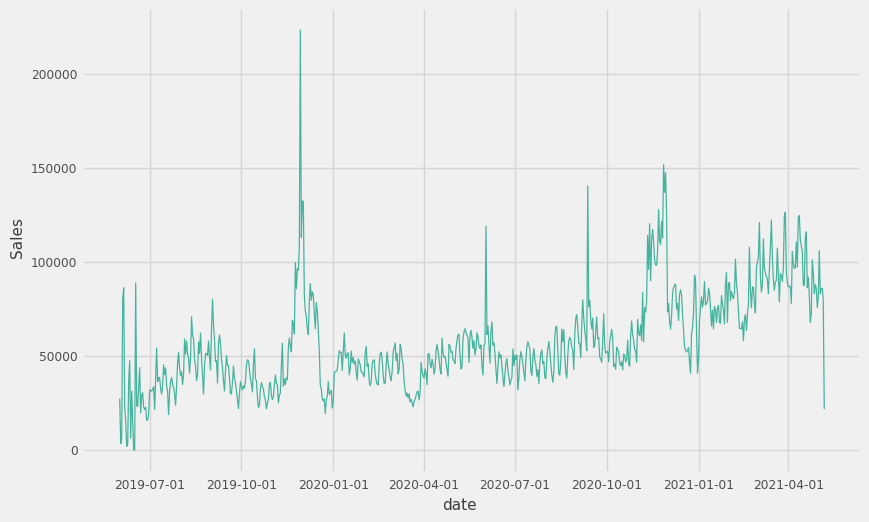

<ggplot: (8771423446902)>

In [407]:
import plotnine

import plotnine
p = (
    ggplot(daily_sales, aes(x='daily_sales.index', y='sales'))
    + geom_line(color='#45B39D') # line plot
    + labs(x='date', y='Sales')
    + plotnine.theme_538()
    + plotnine.theme(figure_size=(10, 6))
)
p

<AxesSubplot:xlabel='date'>

<Figure size 864x576 with 0 Axes>

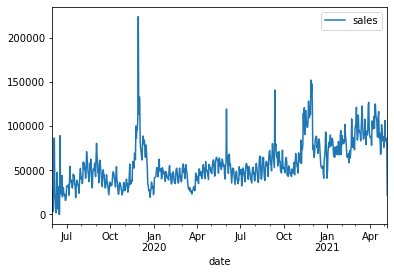

In [408]:
plt.figure(figsize=(12, 8))
daily_sales.plot()

<AxesSubplot:xlabel='date'>

<Figure size 864x576 with 0 Axes>

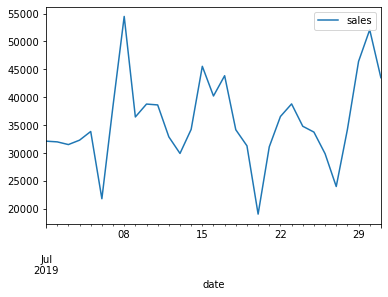

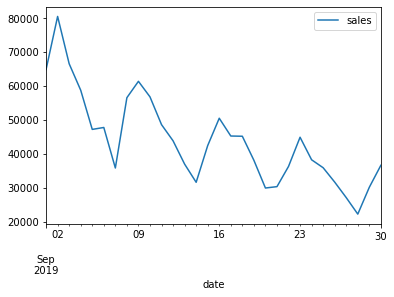

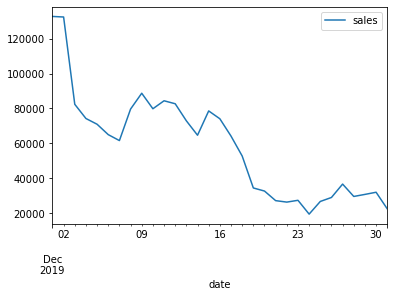

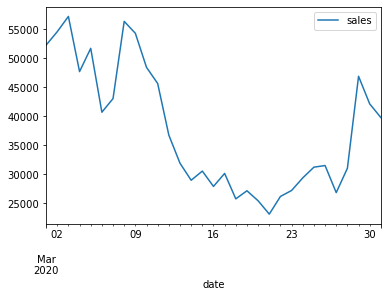

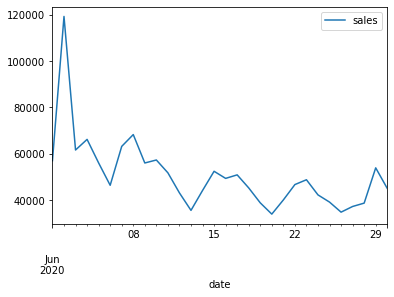

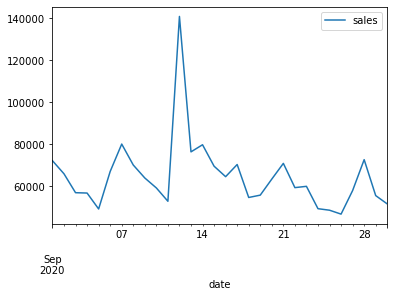

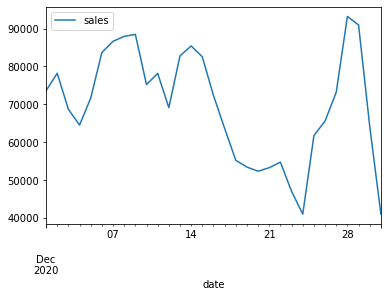

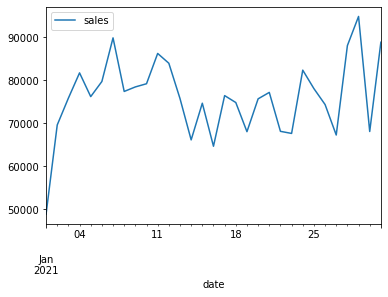

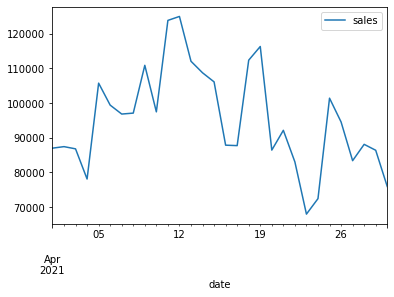

In [409]:
fig=plt.figure(figsize=(12, 8))
daily_sales[((daily_sales.index.year==2019) & (daily_sales.index.month==7))].plot()
daily_sales[((daily_sales.index.year==2019) & (daily_sales.index.month==9))].plot()
daily_sales[((daily_sales.index.year==2019) & (daily_sales.index.month==12))].plot()
daily_sales[((daily_sales.index.year==2020) & (daily_sales.index.month==3))].plot()
daily_sales[((daily_sales.index.year==2020) & (daily_sales.index.month==6))].plot()
daily_sales[((daily_sales.index.year==2020) & (daily_sales.index.month==9))].plot()
daily_sales[((daily_sales.index.year==2020) & (daily_sales.index.month==12))].plot()
daily_sales[((daily_sales.index.year==2021) & (daily_sales.index.month==1))].plot()
daily_sales[((daily_sales.index.year==2021) & (daily_sales.index.month==4))].plot()


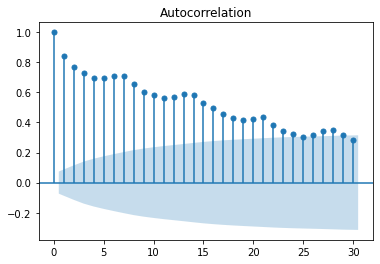

In [410]:
sm.graphics.tsa.plot_acf(daily_sales['sales'], lags=30)
plt.show()

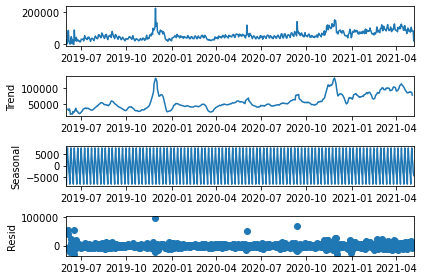

In [411]:

result = seasonal_decompose(daily_sales, model='additive')
result.plot()
pyplot.show()

In [412]:
# Featuring
from tsextract.feature_extraction.extract import build_features, build_features_forecast
from tsextract.domain.statistics import mean, median, std

features_request = {
    "window": [30],
    "window_statistic": [30, mean], 
    "difference_statistic": [30, 1, std], 
    "momentum_statistic": [30, 1, mean],
    "force_statistic": [30, 1, median]
}

#source: https://pypi.org/project/tsextract/

In [413]:
df=build_features(daily_sales.sales, features_request, target_lag=7, include_tzero=True)
df.head()

,T-30,T-29,T-28,T-27,T-26,T-25,T-24,T-23,T-22,T-21,...,T-4,T-3,T-2,T-1,window_statistic_30_mean,difference_statistic_30_1_std,momentum_statistic_30_1_mean,force_statistic_30_1_median,tzero,Target_Tplus7
Date,,,,,,,,,,,,,,,,,,,,,
2019-07-01,27686.366016,3511.559646,7006.124367,80530.520659,86484.287754,23337.229031,15453.449009,2042.718493,3520.393234,36817.735858,...,22881.846834,16024.967234,16151.828680,19516.420649,26713.787433,30525.382893,1267.758534,1204.069956,32106.611780,54496.679436
2019-07-02,3511.559646,7006.124367,80530.520659,86484.287754,23337.229031,15453.449009,2042.718493,3520.393234,36817.735858,47678.421052,...,16024.967234,16151.828680,19516.420649,32106.611780,26861.128958,30522.272746,-124.881248,126.861446,31979.620299,36452.503431
2019-07-03,7006.124367,80530.520659,86484.287754,23337.229031,15453.449009,2042.718493,3520.393234,36817.735858,47678.421052,6473.885091,...,16151.828680,19516.420649,32106.611780,31979.620299,27810.064313,27259.706723,-2552.021361,-91.832202,31495.397121,38767.122681
2019-07-04,80530.520659,86484.287754,23337.229031,15453.449009,2042.718493,3520.393234,36817.735858,47678.421052,6473.885091,31454.648901,...,19516.420649,32106.611780,31979.620299,31495.397121,28626.373405,27226.034041,-178.064586,-91.832202,32285.291215,38611.060088
2019-07-05,86484.287754,23337.229031,15453.449009,2042.718493,3520.393234,36817.735858,47678.421052,6473.885091,31454.648901,15893.319183,...,32106.611780,31979.620299,31495.397121,32285.291215,27018.199090,24641.439601,2231.215583,126.861446,33843.484391,32879.940123


In [414]:
df.isnull().sum()

T-30                             0
T-29                             0
T-28                             0
T-27                             0
T-26                             0
T-25                             0
T-24                             0
T-23                             0
T-22                             0
T-21                             0
T-20                             0
T-19                             0
T-18                             0
T-17                             0
T-16                             0
T-15                             0
T-14                             0
T-13                             0
T-12                             0
T-11                             0
T-10                             0
T-9                              0
T-8                              0
T-7                              0
T-6                              0
T-5                              0
T-4                              0
T-3                              0
T-2                 

In [415]:
print(df.shape)
print(daily_sales.shape)

(670, 36)
(707, 1)


In [416]:
# Applying standard scaler on my data
feature_scaling=StandardScaler().fit(df[df.columns.values[:-1]])
scaled_features=feature_scaling.transform(df[df.columns[:-1]])

label_scaling=StandardScaler().fit(np.array(df[df.columns.values[-1]]).reshape(-1, 1))
scaled_label=label_scaling.transform(np.array(df[df.columns.values[-1]]).reshape(-1, 1))


In [417]:
# splitting data into train and test
training_size=int(scaled_features[:, :-1].shape[0] * 0.75)

X_train, y_train=scaled_features[:training_size, :-1], scaled_label[:training_size, :]
X_test, y_test=scaled_features[training_size:, :-1], scaled_label[training_size:, :]

In [418]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(502, 34)
(502, 1)
(168, 34)
(168, 1)


In [419]:
# Model Training

model=Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, kernel_initializer='normal'))

model.compile(loss='mean_squared_error', optimizer='adam')

history=model.fit(x=X_train, y=y_train, batch_size=32, epochs=100, verbose=1)

Epoch 1/100
16/16 [==============================] - 1s 2ms/step - loss: 0.7686
Epoch 2/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5506
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 0.4964
Epoch 4/100
16/16 [==============================] - 0s 3ms/step - loss: 0.5234
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 0.3080
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 0.4226
Epoch 7/100
16/16 [==============================] - 0s 3ms/step - loss: 0.4907
Epoch 8/100
16/16 [==============================] - 0s 3ms/step - loss: 0.3615
Epoch 9/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2857
Epoch 10/100
16/16 [==============================] - 0s 2ms/step - loss: 0.3062
Epoch 11/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2886
Epoch 12/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2781
Epoch 13/100
16/16 [=================

In [420]:
# Model Evaluation
eval=model.evaluate(x=X_test, y=y_test, verbose=1)
y_pred=model.predict(X_test)

6/6 [==============================] - 0s 1ms/step - loss: 1.3499


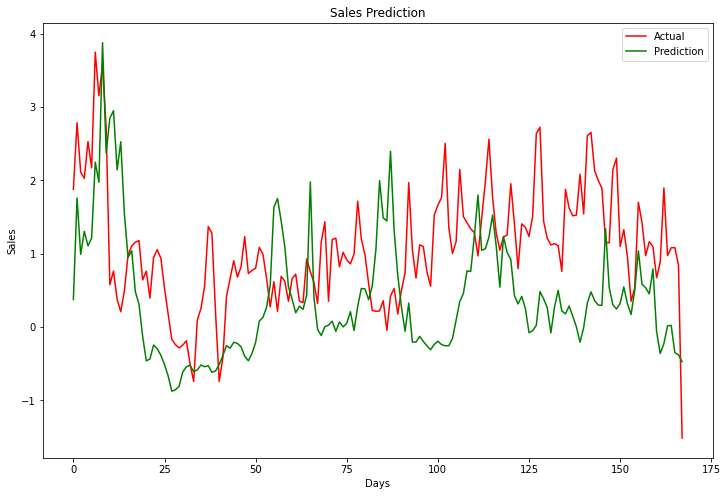

In [421]:
# comparing the prediction with actual
plt.figure(figsize=(12, 8))
plt.plot(y_test.reshape(-1, ), color='red', label='Actual')
plt.plot(y_pred.reshape(-1, ), color='green', label='Prediction')
plt.title('Sales Prediction')
plt.xlabel('Days')
plt.ylabel('Sales')
plt.legend()
plt.show()

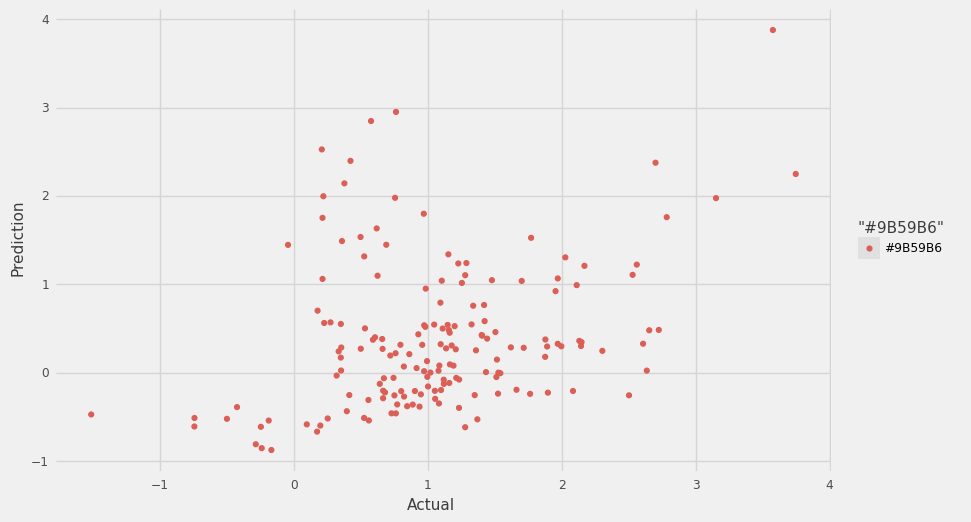

In [422]:
scatter(y_test.reshape(-1, ), y_pred.reshape(-1))

In [423]:
# Forecasting
forecast=build_features_forecast(daily_sales.sales, features_request, include_tzero=True)
scaled_features_forecast=scaler_features.transform(forecast.tail(7))
pred=model.predict(scaled_features_forecast[: , :-1])

pred=scaler_label.inverse_transform(pred)


In [424]:
#range for the next 7 days
range=pd.date_range(start=df.index[-1]+timedelta(days=1), end=df.index[-1]+timedelta(days=7))
range.freq=None
range=range.to_list()



In [425]:
#Daily sales prediction for 7 days
pred

array([[45534.266],
       [48698.305],
       [49411.953],
       [52860.98 ],
       [52176.387],
       [50865.492],
       [44278.902]], dtype=float32)

In [426]:
# Checking the accuracy of the model
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(y_test, y_pred)
print('MSE: %f' % mse)

MSE: 1.349933


In [427]:
from numpy import sqrt
mse=mean_squared_error(y_test, y_pred)
rmse=sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 1.161866
